In [1]:
import keras
keras.__version__

C:\Users\yueki\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [2]:
# 6-28

import os
data_dir = 'jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

# Climate Dataset 
##https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')

lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
#6-29
import numpy as np

float_data = np.zeros((len(lines), len(header) -1 ))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


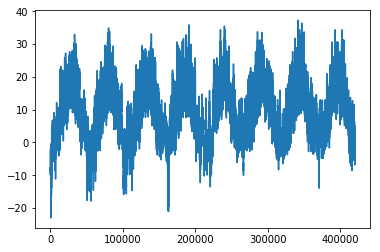

In [6]:
#6-30

from matplotlib import pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

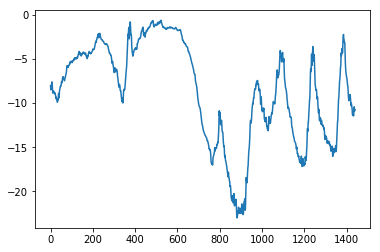

In [7]:
#6-31
plt.plot(range(1440),temp[:1440])
plt.show()

In [8]:
# 6-32

mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

In [16]:
# List 6-33
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index,
                                    size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_ndex + lookback
            rows = np.arange(i,min(i,  batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j],step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
            
        

In [17]:
# List 6-34

lookback = 1440
step = 6
delay = 144
batch_size = 128


train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=20000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size 
                     )

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=20001,
                     max_index=30000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size 
                     )

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=30001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size 
                     )

val_steps = (30000 - 20001 -lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size 

In [35]:
# List 6-35

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes)) 

evaluate_naive_method()
celsius_mae = 0.29 * std[1]
print(celsius_mae , "Celsius")

0.34150444752661324
2.2169252476686387 Celsius


In [45]:
# List 6-37
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 1.7335 - val_loss: 2.5840
Epoch 2/20
500/500 [==============================] - 16s 33ms/step - loss: 0.8546 - val_loss: 1.0590
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4629 - val_loss: 0.6941
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2837 - val_loss: 0.9033
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1971 - val_loss: 0.5560
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1572 - val_loss: 0.8169
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1332 - val_loss: 0.5496
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.1198 - val_loss: 0.5202
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.1093 - val_loss: 0.5101
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.102

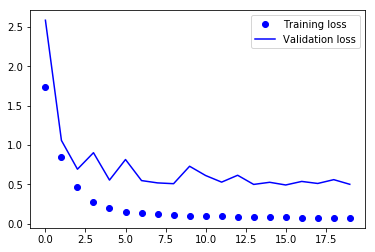

In [46]:
# List 6-38
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss,'bo',label='Training loss' )
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [21]:
# 6-39
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500,
                              epochs=2,
                              validation_data=val_gen,
                              validation_steps=val_steps
                              )

Epoch 1/2
500/500 [==============================] - 103s 205ms/step - loss: 0.2864 - val_loss: 0.3733
Epoch 2/2
500/500 [==============================] - 102s 204ms/step - loss: 0.2257 - val_loss: 0.4082


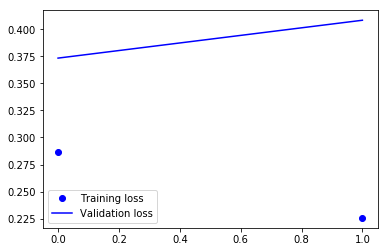

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss,'bo',label='Training loss' )
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()